# Notebook to downscale temperatures from a weather station to a glacier surface

### Requirements:
### - daily AWS temperature data AND/OR ERA5 daily temperature data
### - AWS elevation (m)
### - yearly DEMs
### - (optional) NODATA value in DEMs
### - csv containing lon/lat coordinates from terminus to headwall

## import libraries

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import calendar
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import geopandas as gpd
from pyproj import Transformer

## modify inputs

In [2]:
#inputs - WOLVERINE

#path to USGS weather station data
aws_path = '/Users/lindsaysummers/Documents/Research/Mass_Balance/USGS/benchmarkGlaciers_massBalance_inputOutput/Wolverine/'
aws_filename = 'Input_Wolverine_Daily_Weather.csv'

#path to ERA5 temperature data
era5_path = '/Users/lindsaysummers/Documents/Research/ERA5/Wolverine/'
era5_filename = 'daily_temp_2020-2021.csv'
era_startdate = '2020-10-19'
era_enddate = '2021-04-01'

#elevation of usgs weather station temperatuer data is from
aws_elevation = 990

#lapse rate (°C/m)
#lapse_rate = 0.005042161692263112 #from previous calculations
lapse_rate = 0.0065

#start and end date (YYYY-mm-dd)
start_date = '2015-01-01'
end_date = '2024-12-31'

#path to DEMs
dem_path = '/Users/lindsaysummers/Documents/Research/DEMs/Wolverine/yearly/'

#nodata value in DEMs
nodata_value = -3.4028234663852886e+38

#path to csv with lat/lon points along centerline
#format should be lon/lat in order from terminus to headwall
points_path = '/Users/lindsaysummers/Documents/Research/Velocity/Wolverine/RGI_data/'
points_name = 'centerline_points_latlon_0.5km_spacing.csv'
#points_name = 'centerline_points_latlon_1km_spacing.csv'

#where to store corrected temperature record
out_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Wolverine/15_points/'

In [3]:
#inputs - Gulkana

#path to USGS weather station data
aws_path = '/Users/lindsaysummers/Documents/Research/Mass_Balance/USGS/benchmarkGlaciers_massBalance_inputOutput/Gulkana/'
aws_filename = 'Input_Gulkana_Daily_Weather.csv'

#path to ERA5 temperature data
era5_path = '/Users/lindsaysummers/Documents/Research/ERA5/Gulkana/'
era5_filename = 'daily_temp_2021.csv'
era_startdate = '2021-08-21'
era_enddate = '2021-11-03'

#elevation of usgs weather station temperatuer data is from
aws_elevation = 1725

#lapse rate (°C/m)
#lapse_rate = -0.005376577871853243 #from previous calculations
lapse_rate = 0.0065

#start and end date (YYYY-mm-dd)
start_date = '2015-01-01'
end_date = '2024-12-31'

#path to DEMs
dem_path = '/Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/'

#nodata value in DEMs
nodata_value = -3.4028234663852886e+38

#path to csv with lat/lon points along centerline
#format should be lon/lat in order from terminus to headwall
points_path = '/Users/lindsaysummers/Documents/Research/Velocity/Gulkana/RGI_data/'
points_name = 'centerline_points_latlon_0.5km_spacing.csv'
#points_name = 'centerline_points_latlon_1km_spacing.csv'

#where to store corrected temperature record
out_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Gulkana/15_points/'

## import USGS AWS temperature data

In [4]:
#read in temperature data
aws_path = aws_path + aws_filename
weather_df = pd.read_csv(aws_path)

#extract time and temperature and elevation columns
usgs_time = pd.to_datetime(weather_df['Date'], yearfirst=True)
usgs_temp = weather_df['Temperature']
usgs_station = weather_df['Elevation']

#combine columns to form a new df
weather_df = pd.DataFrame({'time': usgs_time, 'temperature': usgs_temp, 'station': usgs_station})
weather_df = weather_df[weather_df['station'] == aws_elevation] #filter by specified station
weather_df = weather_df.drop(columns=['station'])
print(weather_df)

            time  temperature
20047 2012-04-20         -2.0
20048 2012-04-21         -4.3
20049 2012-04-22         -3.8
20050 2012-04-23         -3.3
20051 2012-04-24         -2.9
...          ...          ...
24589 2024-09-26         -1.3
24590 2024-09-27         -2.4
24591 2024-09-28          NaN
24592 2024-09-29         -3.9
24593 2024-09-30         -2.2

[4547 rows x 2 columns]


## fill aws data gaps with ERA5 data (optional)

In [5]:
#get rid of aws data where ERA5 will be entered
mask = (weather_df['time'] < era_startdate) | (weather_df['time'] > era_enddate)
weather_df = weather_df[mask]
#print(weather_df)

#read in ERA5 temperature data to fill in gaps
era5_path = era5_path + era5_filename
era_data = pd.read_csv(era5_path)
era_data = era_data.drop(columns=['Unnamed: 0'])
#print(era_data)

#make sure time column is in datetime format
#pull time column out and make into a series then convert to datetime format
time_column = era_data['time']
time_column = pd.to_datetime(time_column, yearfirst=True, format='mixed')
era_data['time'] = time_column
    
print(era_data)

         time  temperature
0  2021-08-21     2.596242
1  2021-08-22     2.821910
2  2021-08-23     5.872976
3  2021-08-24     5.513377
4  2021-08-25     5.091248
..        ...          ...
70 2021-10-30    -9.161244
71 2021-10-31    -5.256175
72 2021-11-01    -5.306671
73 2021-11-02    -4.163564
74 2021-11-03    -4.335897

[75 rows x 2 columns]


In [6]:
#combine ERA5 temp data and AWS temp data
weather_df = pd.concat([weather_df, era_data])
weather_df = weather_df.sort_values(by='time')
weather_df = weather_df.reset_index(drop=True)

print(weather_df)

           time  temperature
0    2012-04-20         -2.0
1    2012-04-21         -4.3
2    2012-04-22         -3.8
3    2012-04-23         -3.3
4    2012-04-24         -2.9
...         ...          ...
4542 2024-09-26         -1.3
4543 2024-09-27         -2.4
4544 2024-09-28          NaN
4545 2024-09-29         -3.9
4546 2024-09-30         -2.2

[4547 rows x 2 columns]


In [7]:
#path to ERA5 temperature data
era5_path = '/Users/lindsaysummers/Documents/Research/ERA5/Gulkana/'
era5_filename = 'daily_temp_2022.csv'
era_startdate = '2022-01-31'
era_enddate = '2022-08-26'

#get rid of aws data where ERA5 will be entered
mask = (weather_df['time'] < era_startdate) | (weather_df['time'] > era_enddate)
weather_df = weather_df[mask]
#print(weather_df)

#read in ERA5 temperature data to fill in gaps
era5_path = era5_path + era5_filename
era_data = pd.read_csv(era5_path)
era_data = era_data.drop(columns=['Unnamed: 0'])
#print(era_data)

#make sure time column is in datetime format
#pull time column out and make into a series then convert to datetime format
time_column = era_data['time']
time_column = pd.to_datetime(time_column, yearfirst=True, format='mixed')
era_data['time'] = time_column
    
print(era_data)

          time  temperature
0   2022-01-31   -21.541811
1   2022-02-01   -20.732811
2   2022-02-02   -19.904311
3   2022-02-03   -22.289902
4   2022-02-04   -18.085917
..         ...          ...
203 2022-08-22     7.481908
204 2022-08-23     6.466747
205 2022-08-24     4.896591
206 2022-08-25     3.653828
207 2022-08-26     3.102972

[208 rows x 2 columns]


In [8]:
#combine ERA5 temp data and AWS temp data
weather_df = pd.concat([weather_df, era_data])
weather_df = weather_df.sort_values(by='time')
weather_df = weather_df.reset_index(drop=True)

print(weather_df)

           time  temperature
0    2012-04-20         -2.0
1    2012-04-21         -4.3
2    2012-04-22         -3.8
3    2012-04-23         -3.3
4    2012-04-24         -2.9
...         ...          ...
4542 2024-09-26         -1.3
4543 2024-09-27         -2.4
4544 2024-09-28          NaN
4545 2024-09-29         -3.9
4546 2024-09-30         -2.2

[4547 rows x 2 columns]


## create temperature dataframes for each year

In [9]:
weather_df = weather_df[(weather_df['time'] >= start_date) & (weather_df['time'] <= end_date)]
years =  weather_df['time'].dt.year.unique()
yearly_dataframes = {}
for year in years:
    yearly_dataframes[year] = weather_df[weather_df['time'].dt.year == year].copy()

## import DEMs for each year

In [10]:
DEMs = {}  # dictionary to store DEM file paths

for year in years:
    for file in os.listdir(dem_path):
        if file.endswith(f'{year}.tif'):
            file_path = os.path.join(dem_path, file)
            print(f"Loading {file_path} into DEMs['dem_{year}']")
            DEMs[f'dem_{year}'] = file_path  # store the file path

Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2015.tif into DEMs['dem_2015']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2016.tif into DEMs['dem_2016']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2017.tif into DEMs['dem_2017']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2018.tif into DEMs['dem_2018']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2019.tif into DEMs['dem_2019']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2020.tif into DEMs['dem_2020']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2021.tif into DEMs['dem_2021']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2022.tif into DEMs['dem_2022']
Loading /Users/lindsaysummers/Documents/Research/DEMs/Gulkana/yearly/Gulkana_DEM_2023.tif into DEMs['dem

## define lon/lat points

In [11]:
#import csv containing lat lon points
points_list = pd.read_csv(os.path.join(points_path, points_name))
points_list = points_list.values.tolist()
#print(points_list)

#dictionary to store points
points = {}

for pt in range(len(points_list)):
    points[pt+1] = points_list[pt]
    print(f'point {pt+1} added to points directory')

point 1 added to points directory
point 2 added to points directory
point 3 added to points directory
point 4 added to points directory
point 5 added to points directory
point 6 added to points directory
point 7 added to points directory
point 8 added to points directory
point 9 added to points directory
point 10 added to points directory
point 11 added to points directory
point 12 added to points directory
point 13 added to points directory
point 14 added to points directory
point 15 added to points directory


## extract elevation of each point each year

In [12]:
#change crs to WGS84 and get elevation from lat/lon points
def get_elevation(dem_path, lat, lon):
    with rasterio.open(dem_path) as src:
        if src.crs != 'epsg:4326':
                transformer = Transformer.from_crs("epsg:4326", src.crs, always_xy=True)
                lon, lat = transformer.transform(lon, lat)
        elevation = next(src.sample([(lon, lat)]))[0]
        return elevation

In [13]:
#dictionary to store elevations
elevations = {}

for year, dem_path in DEMs.items():
    elevations[year] = {}
    for pt, coords in points.items():  # pt_num = int, coords = [lon, lat]
        elevation = get_elevation(dem_path, coords[1], coords[0])  # lat=coords[1], lon=coords[0]
        if elevation == nodata_value:
            elevation = np.nan
        elevations[year][f'pt{pt}'] = elevation
#        print(f"Elevation for pt{pt} in {year}: {elevation}")   

## calculate the elevation difference (m) between each point and the AWS for each year

In [14]:
#elevation difference between each point and weather station (m)

#dictionary to store elevation differences
elevation_differences = {}

for year, point in elevations.items():
    elevation_differences[year] = {}
    for pt, elevation in point.items():
        difference = elevation - aws_elevation
        if difference == nodata_value:
            difference = np.nan
        if np.isnan(difference):
            difference = 0.0
        elevation_differences[year][pt] = difference
#        print(f"elevation difference for {pt} in {year}:{difference} m")

## calculate the temperature correction for each point
### lapse rate (°C/m) * elevation difference (m) = correction (°C)

In [15]:
#dictionary to store correction for each point each year
corrections = {}

for year, pts_diffs in elevation_differences.items():
    corrections[year] = {}
    for pt, elevation_diff in pts_diffs.items():
        correction = lapse_rate * elevation_diff
        corrections[year][pt] = correction
#        print(f"temperature correction for {pt} in {year}: {correction:.2f} °C")

## apply corrections to AWS (+ERA5) temperature data for each point

In [16]:
#dictionary to store corrected temperatures
temperatures = {}

for years in corrections:
    year = int(years.replace('dem_',''))
    temp_df = yearly_dataframes[year]
    temperatures[year] = {}
    for pt, correction in corrections[years].items():
        corrected = temp_df['temperature'] - correction
        temperatures[year][pt] = corrected
#        print(f"applied temperature correction for {pt} in {year}")

## plot corrected temperatures for each year

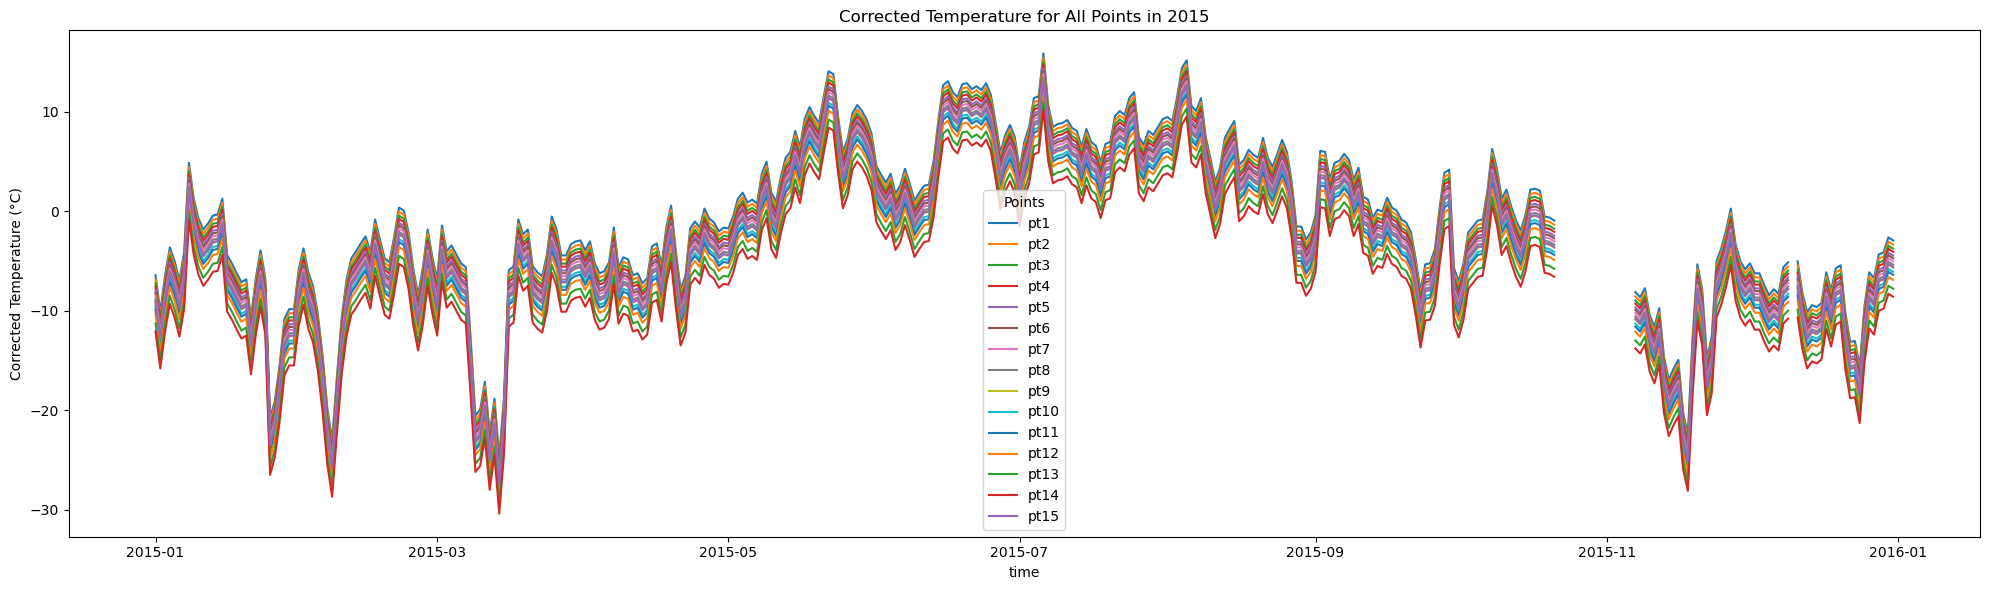

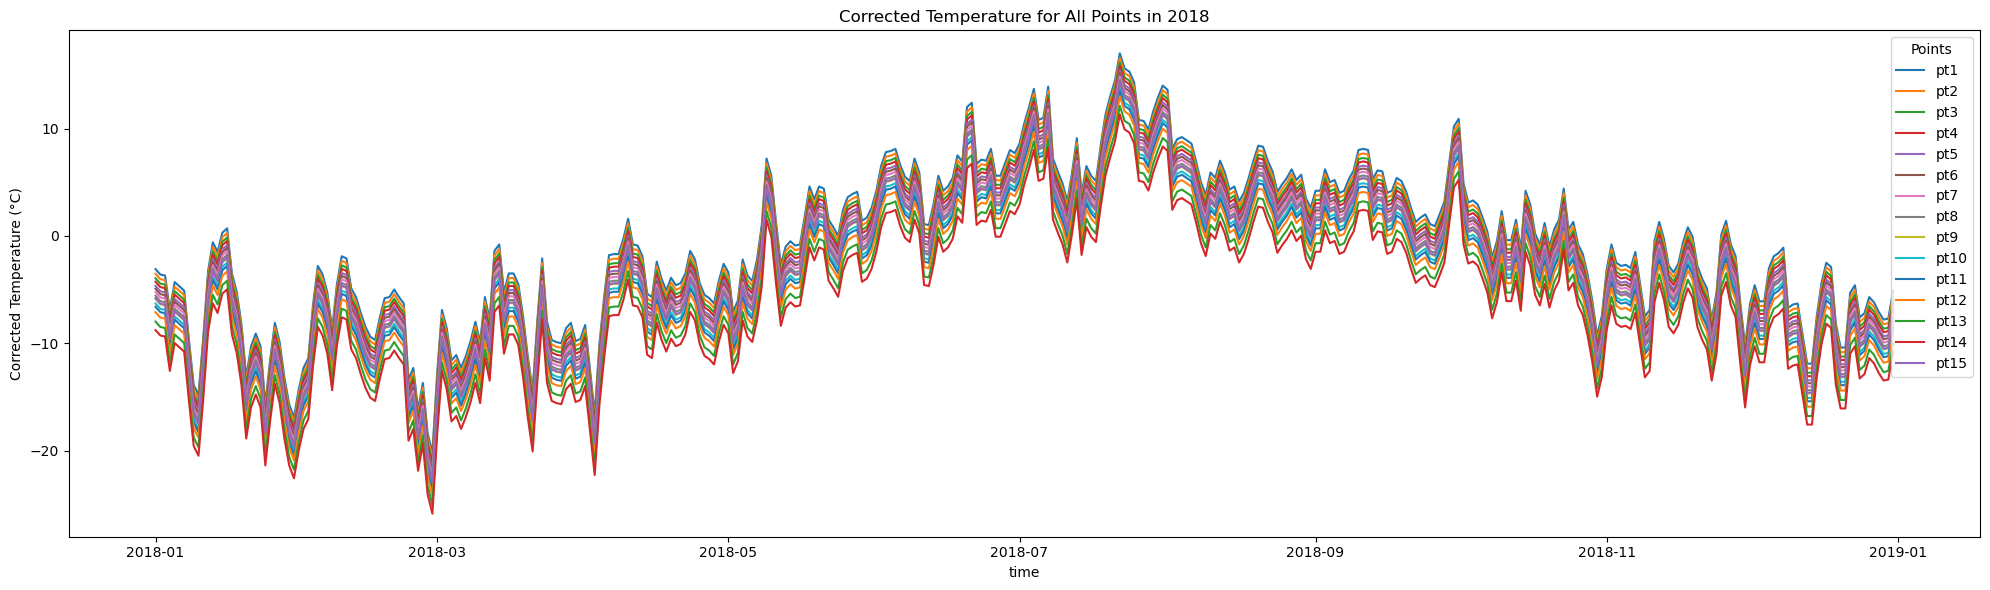

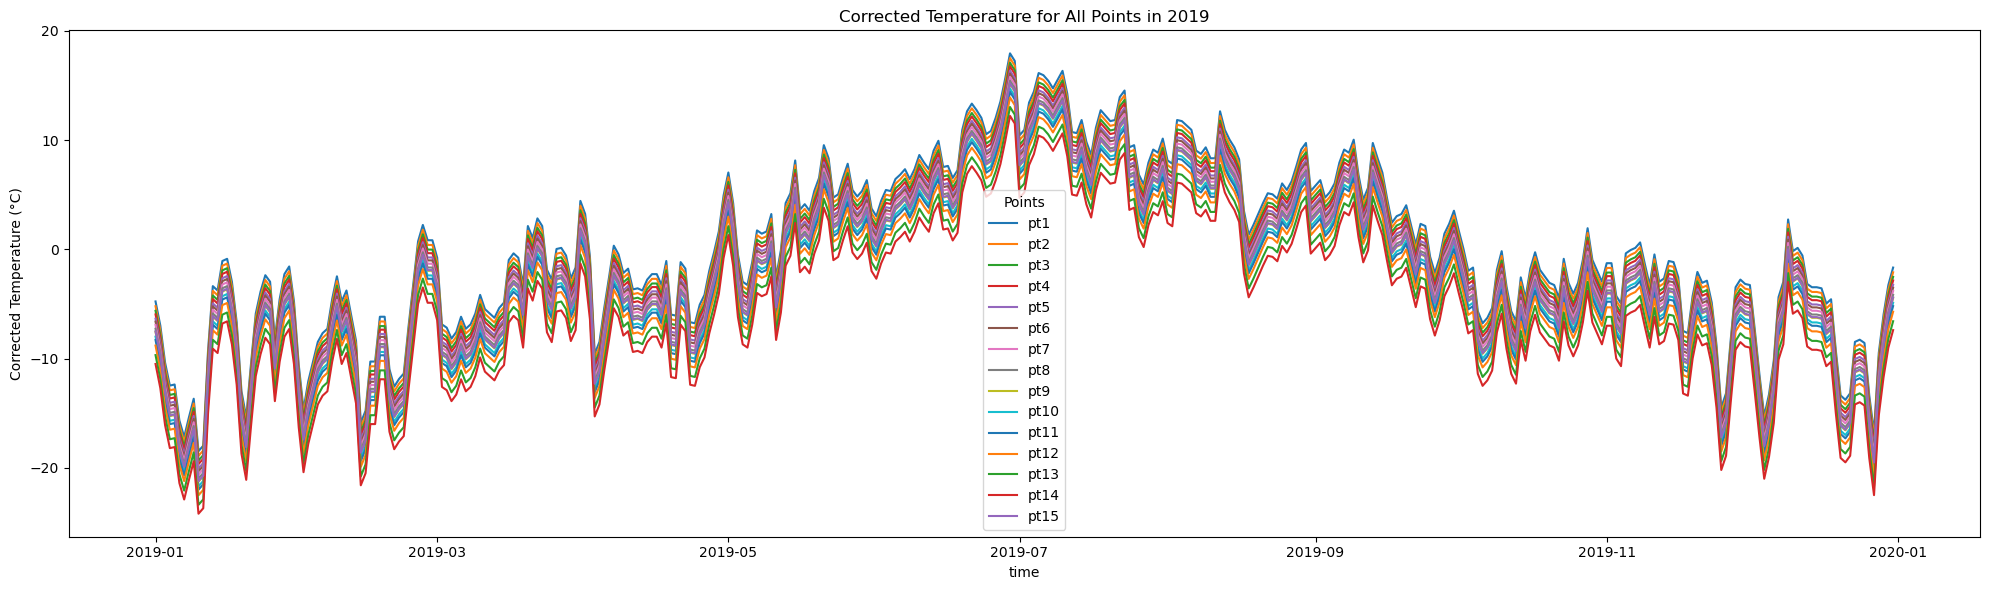

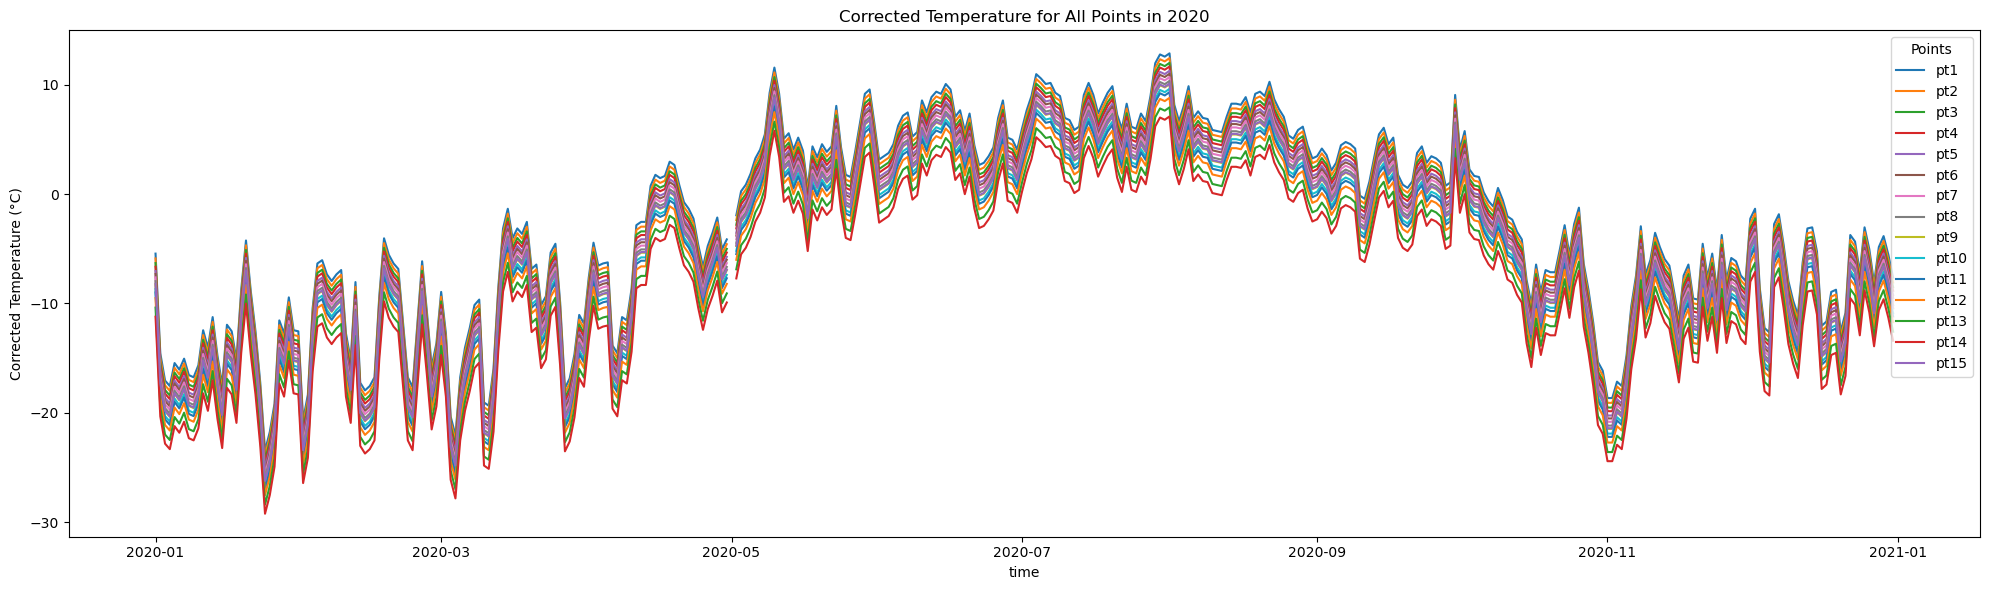

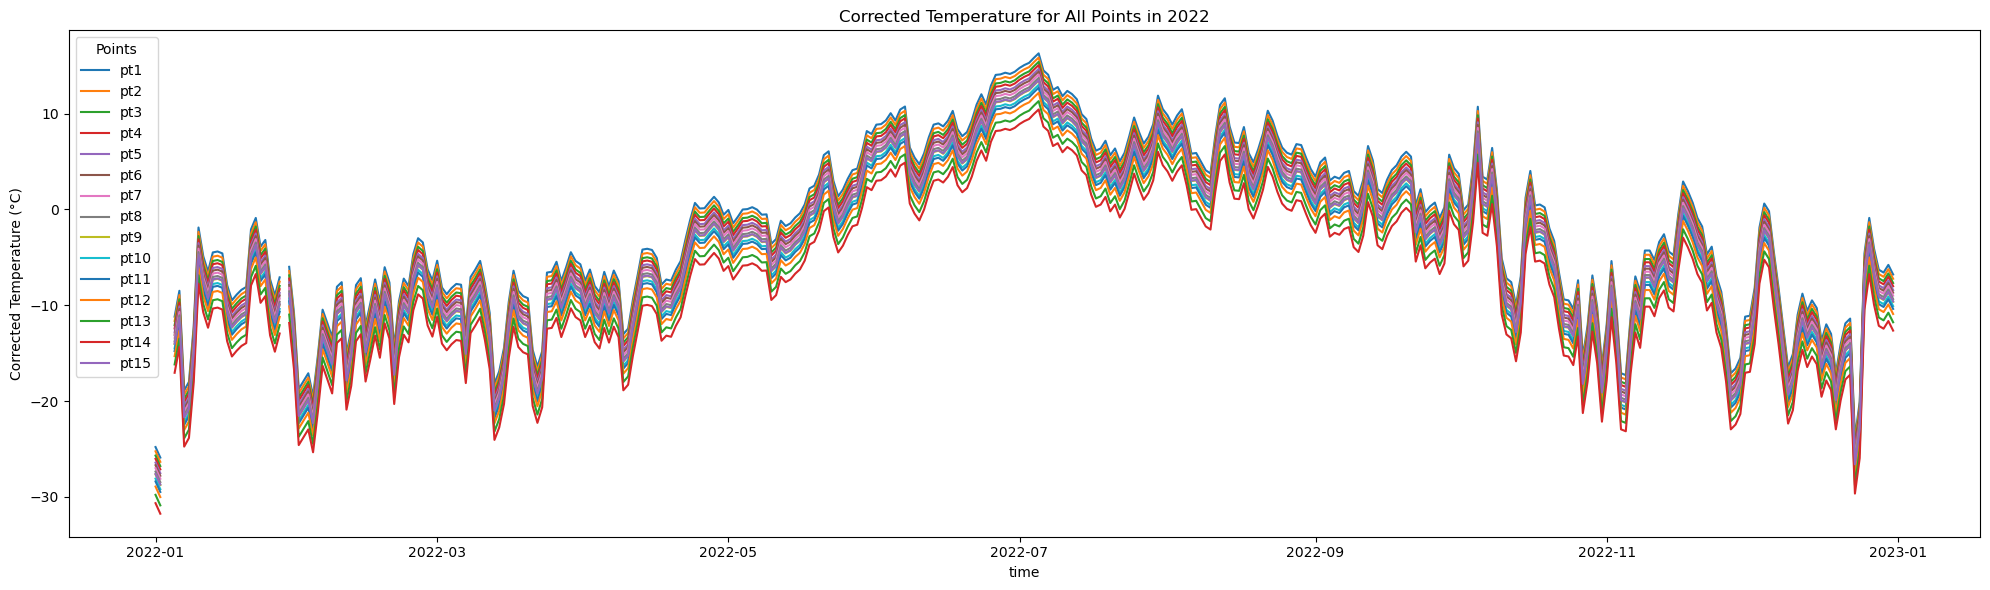

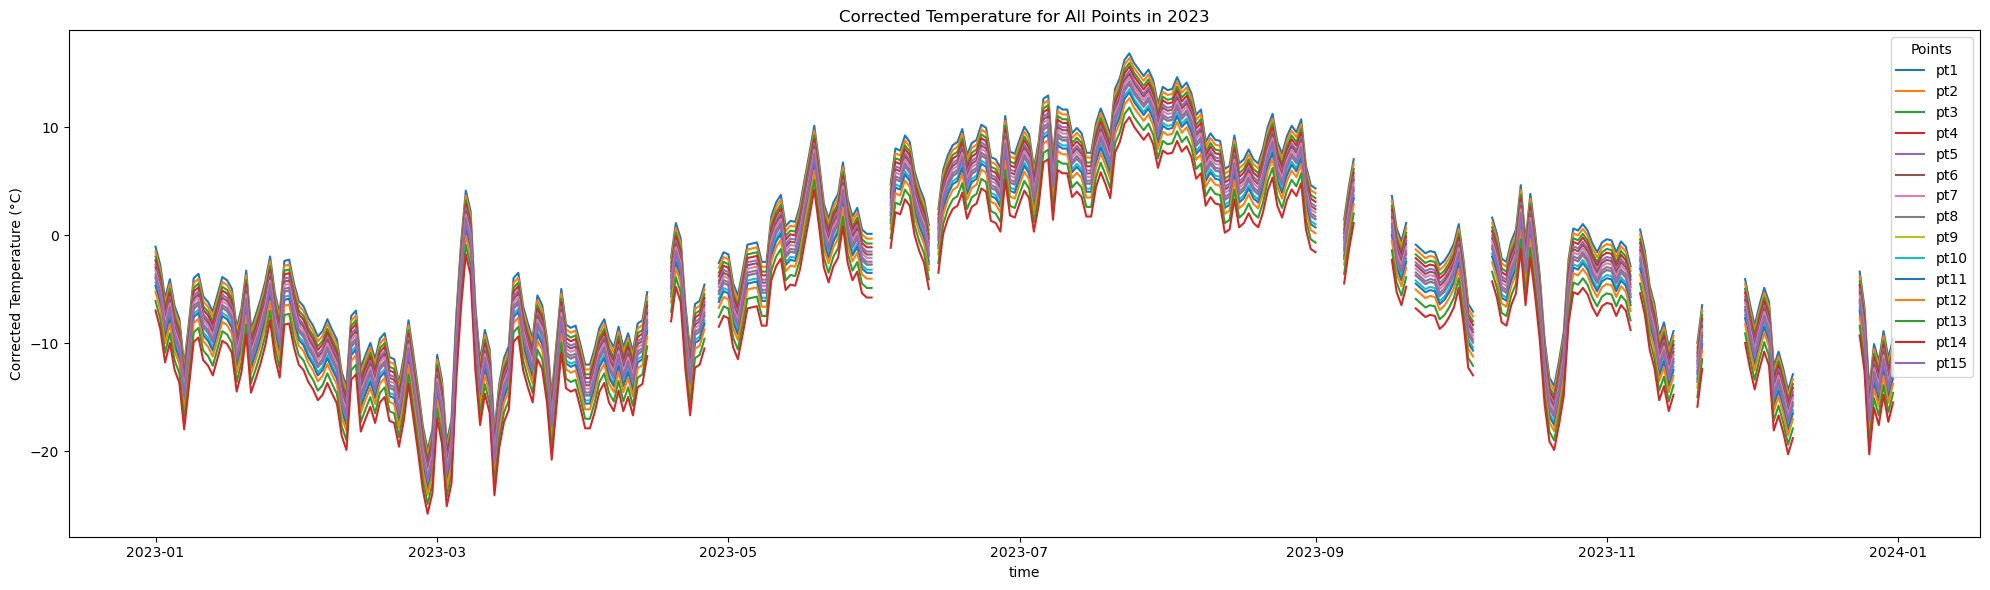

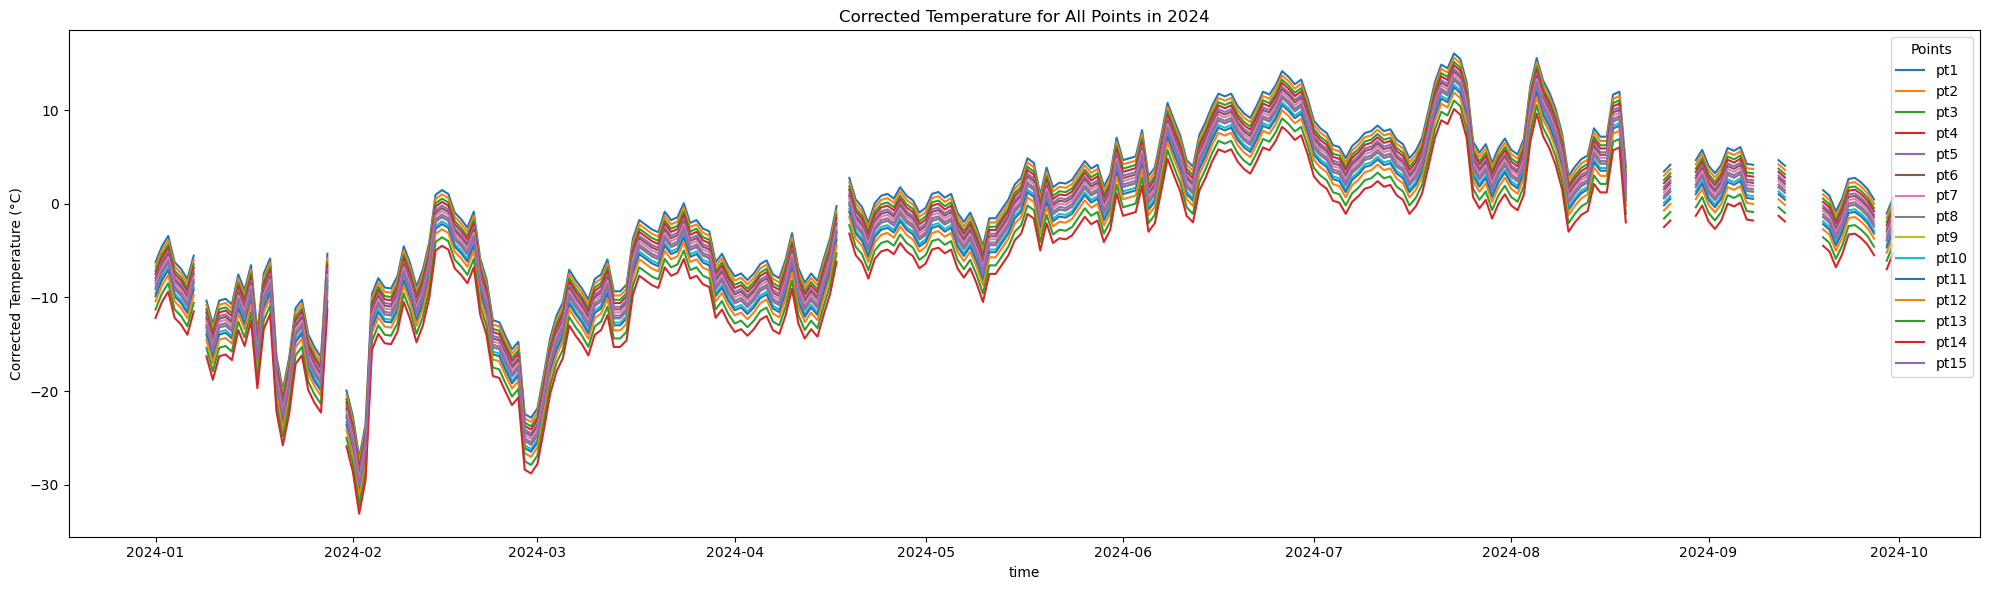

In [17]:
for year, points in temperatures.items():
    temperature_df = yearly_dataframes[year]
    plt.figure(figsize=(20,6))
    for pt, corrected in points.items():
        plt.plot(temperature_df['time'], corrected, label=f'{pt}')

    plt.xlabel('time')
    plt.ylabel('Corrected Temperature (°C)')
    plt.title(f'Corrected Temperature for All Points in {year}')
    plt.legend(title='Points')
    plt.tight_layout()
    plt.show()

## plot corrected temperatures at each point

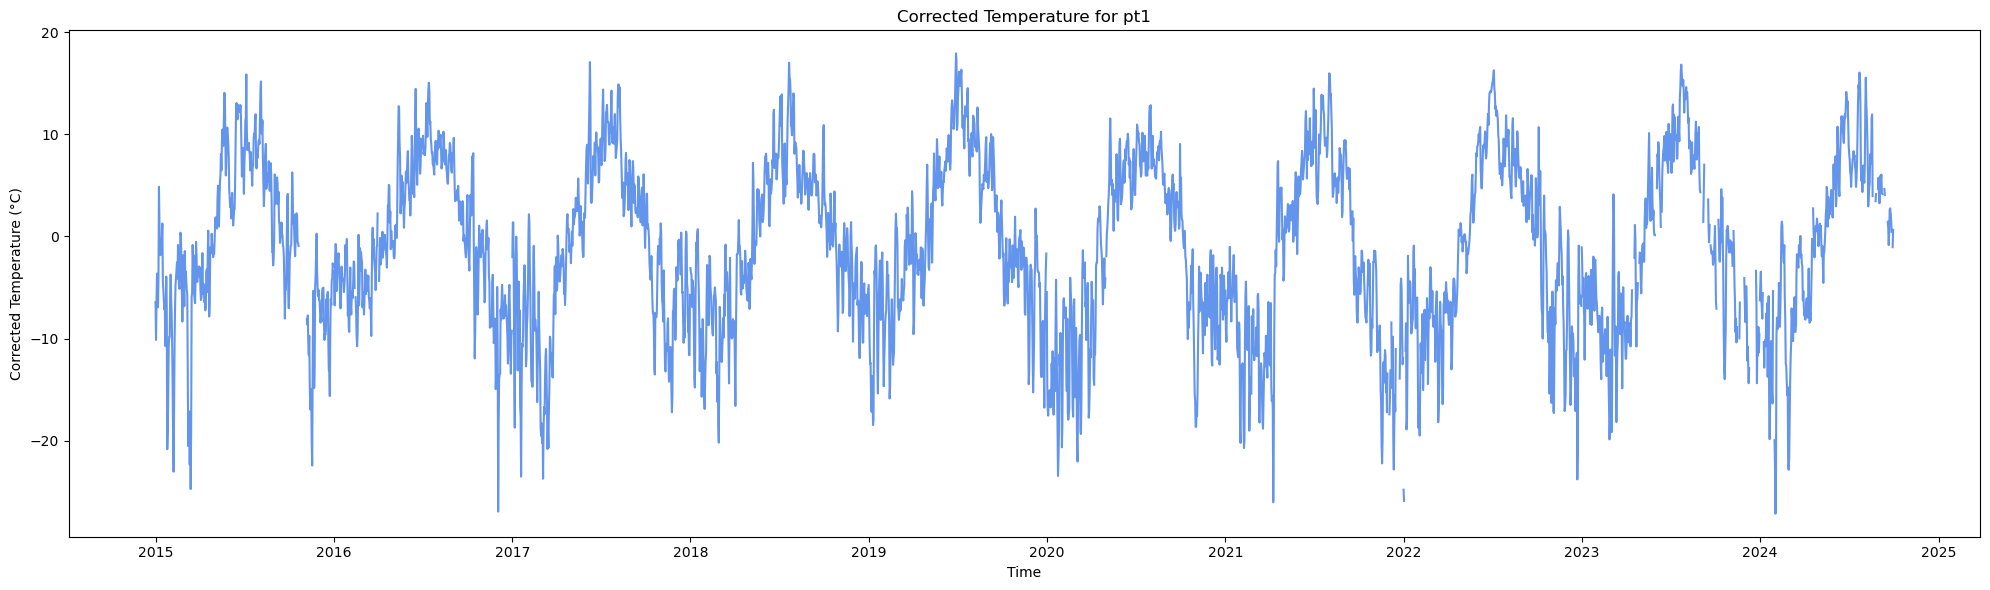

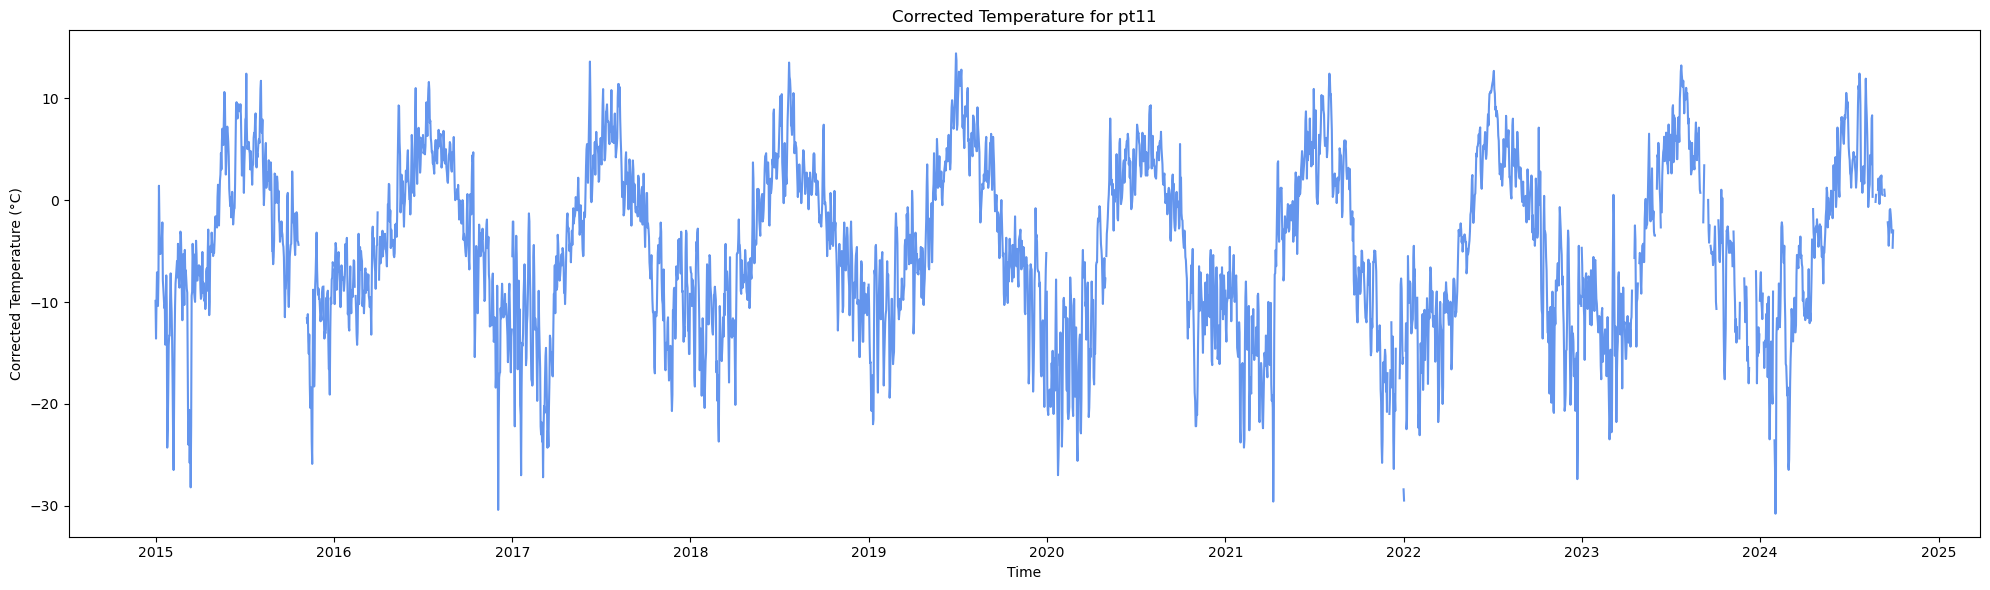

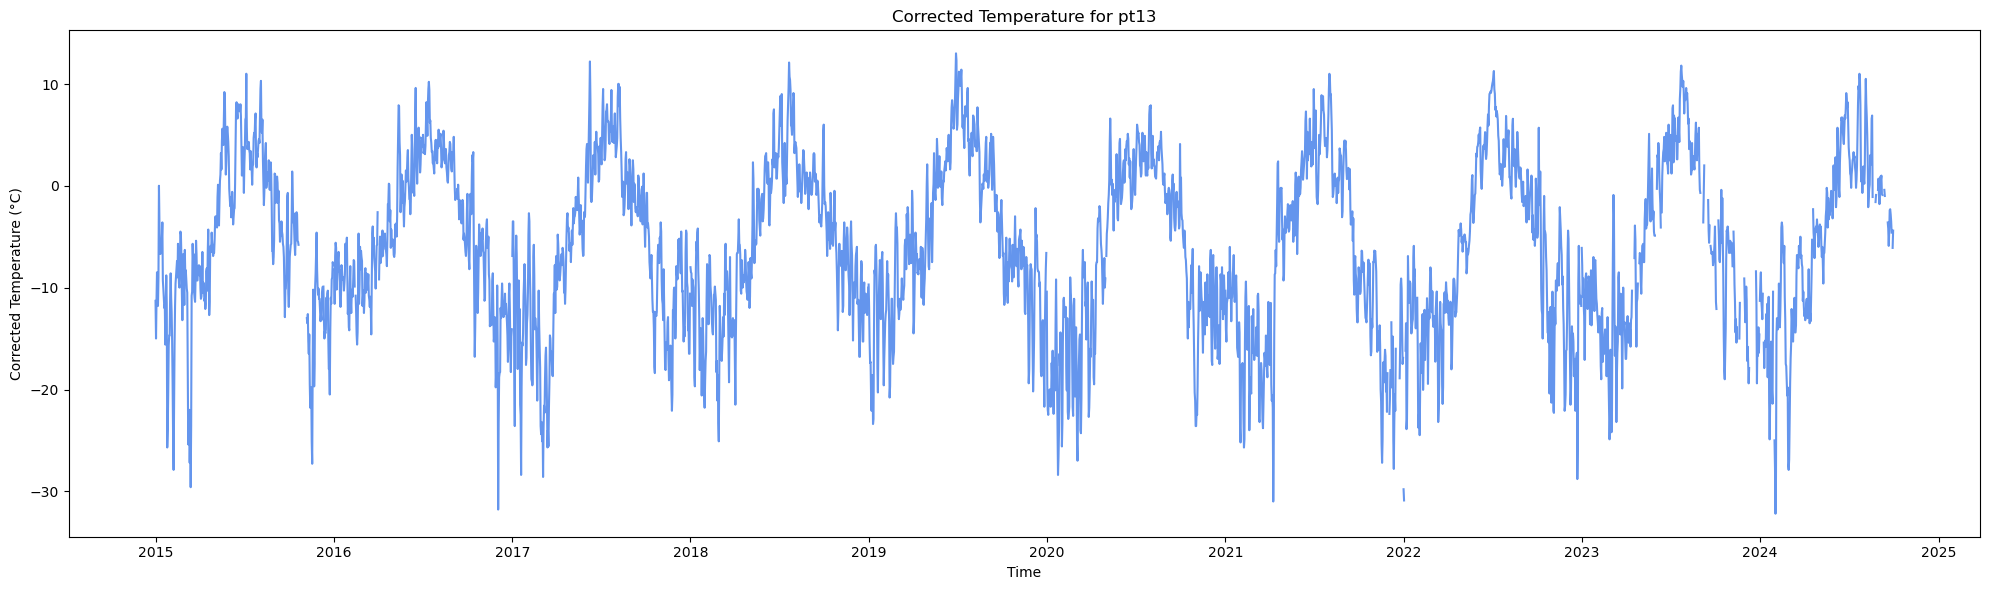

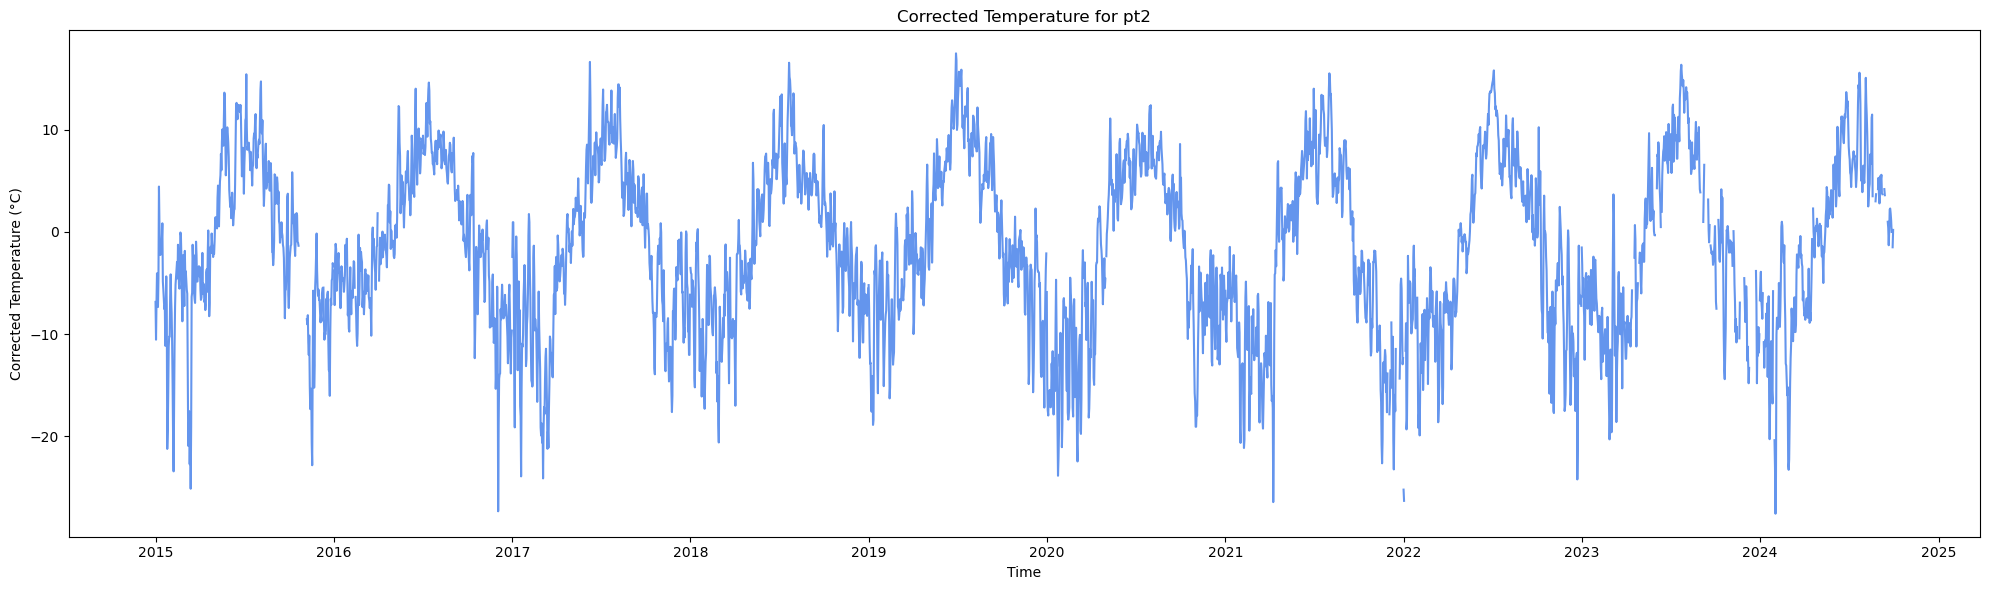

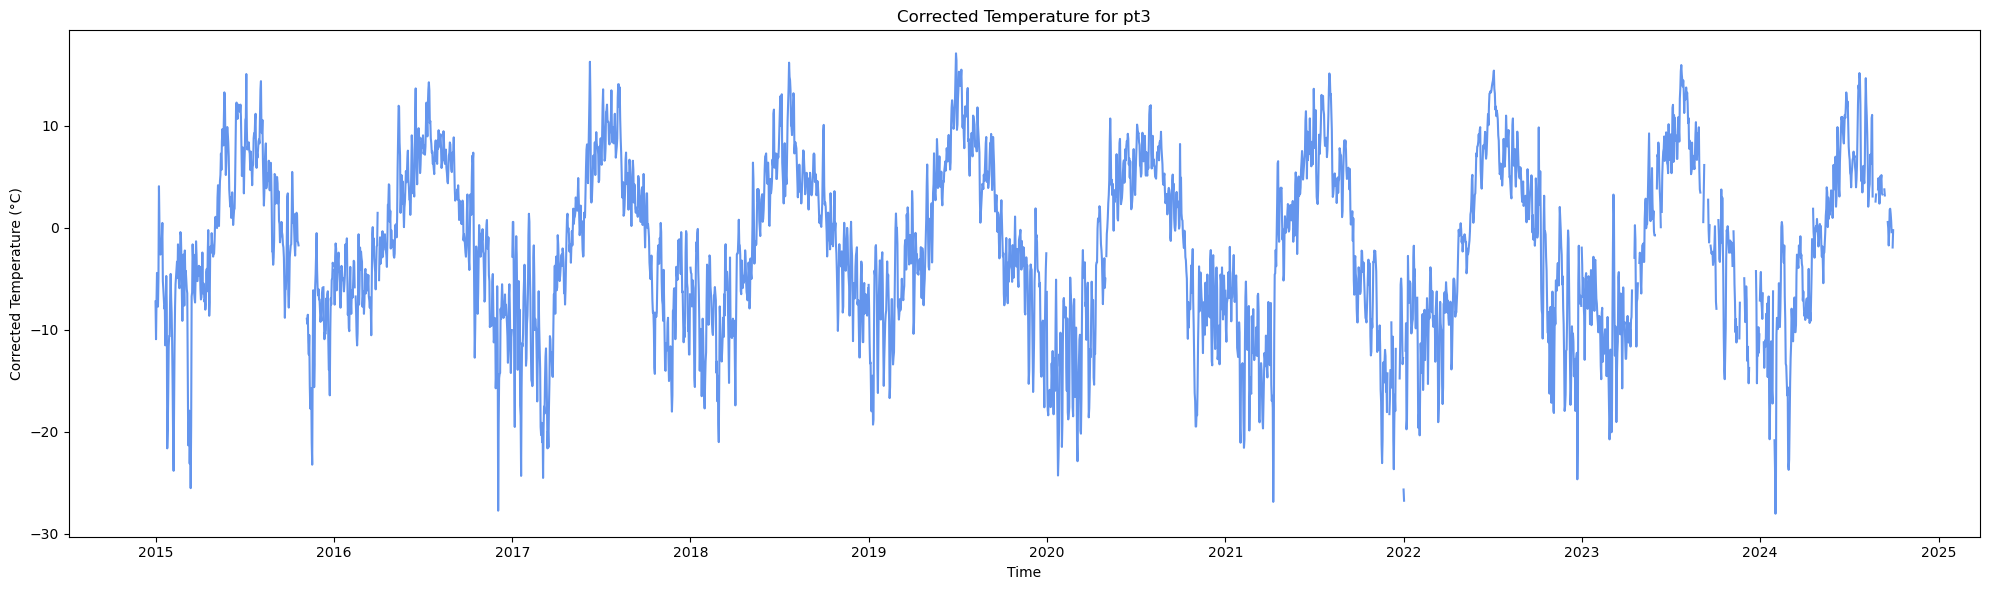

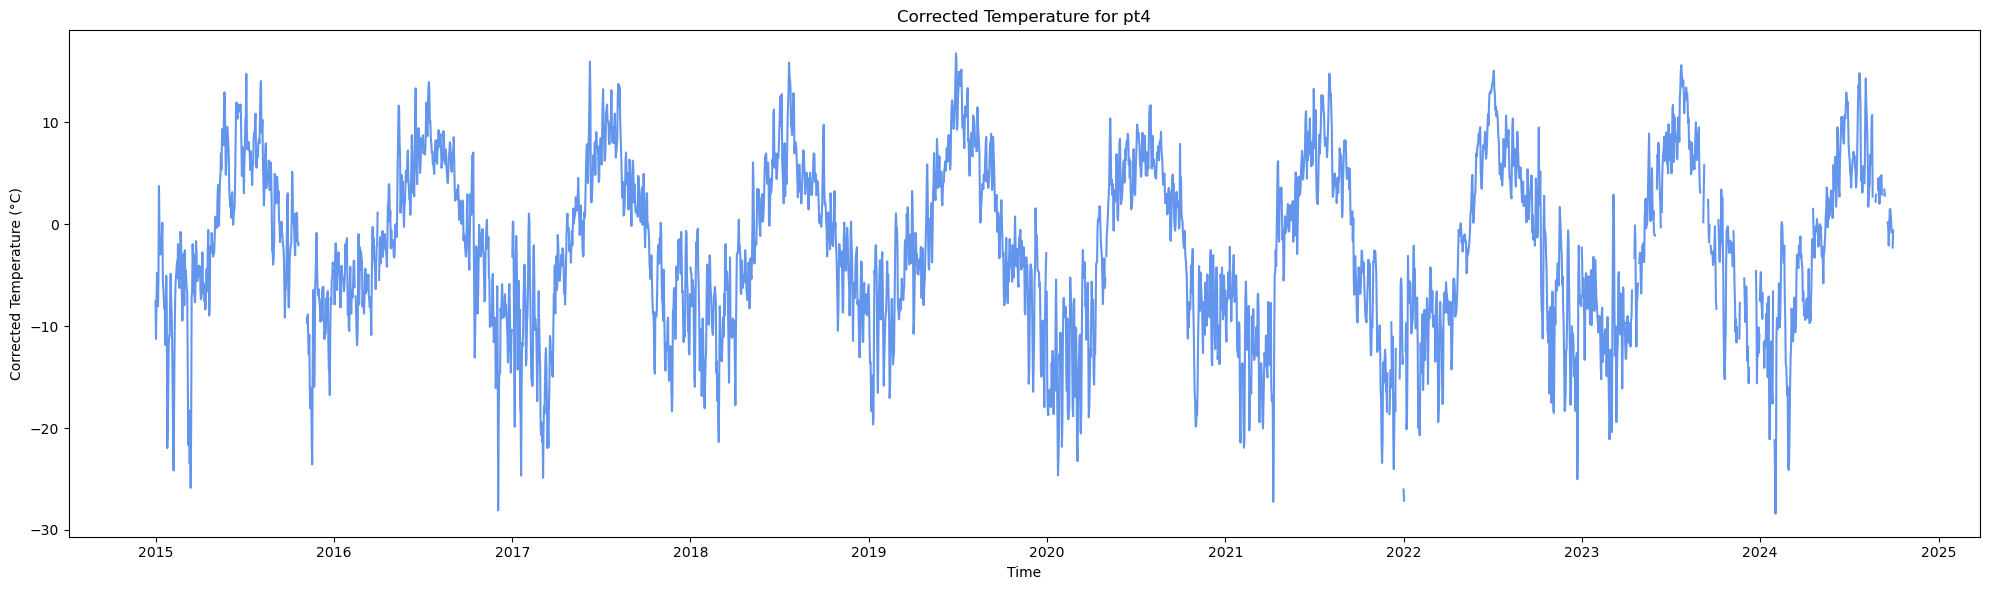

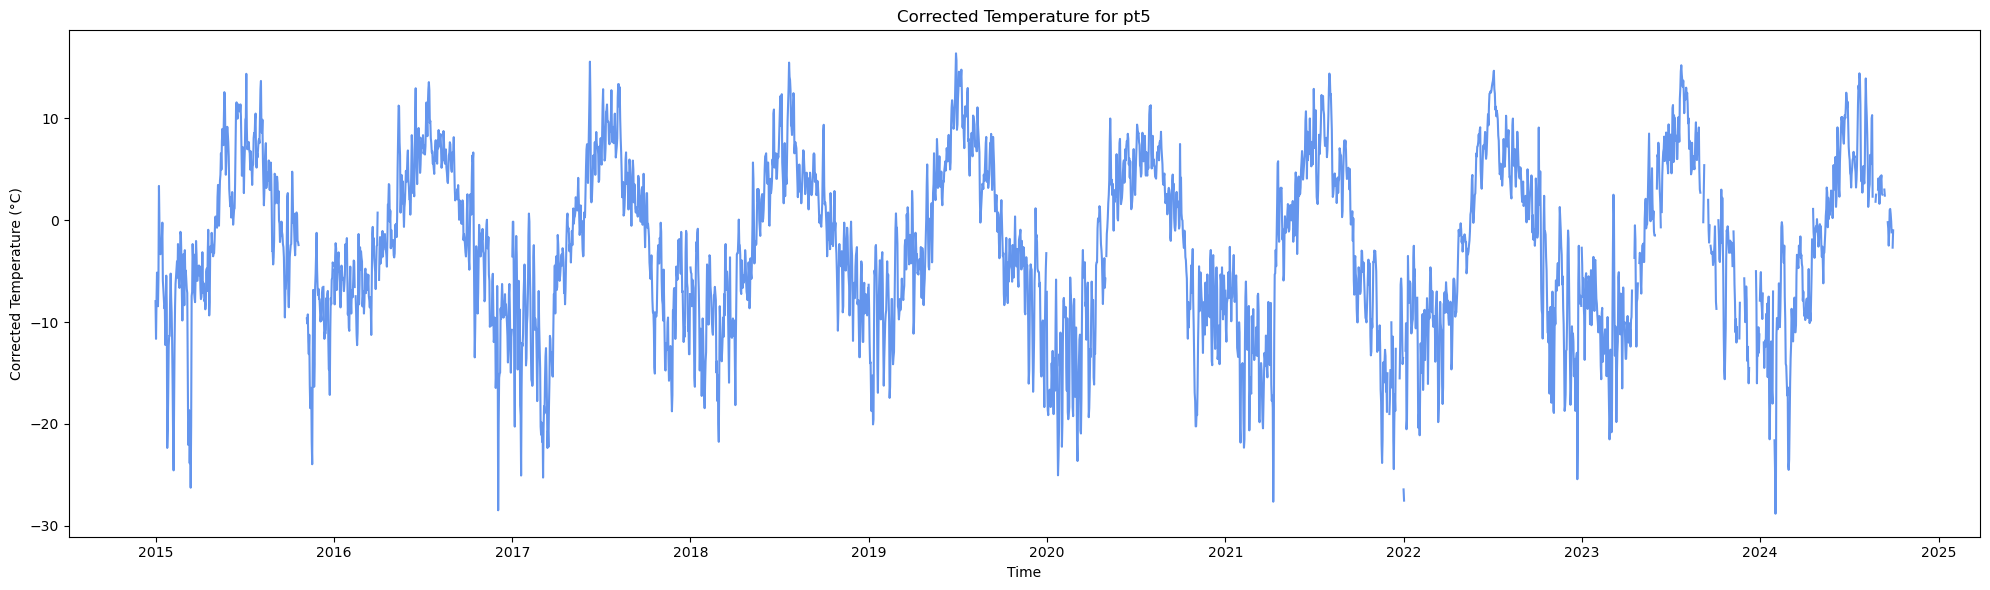

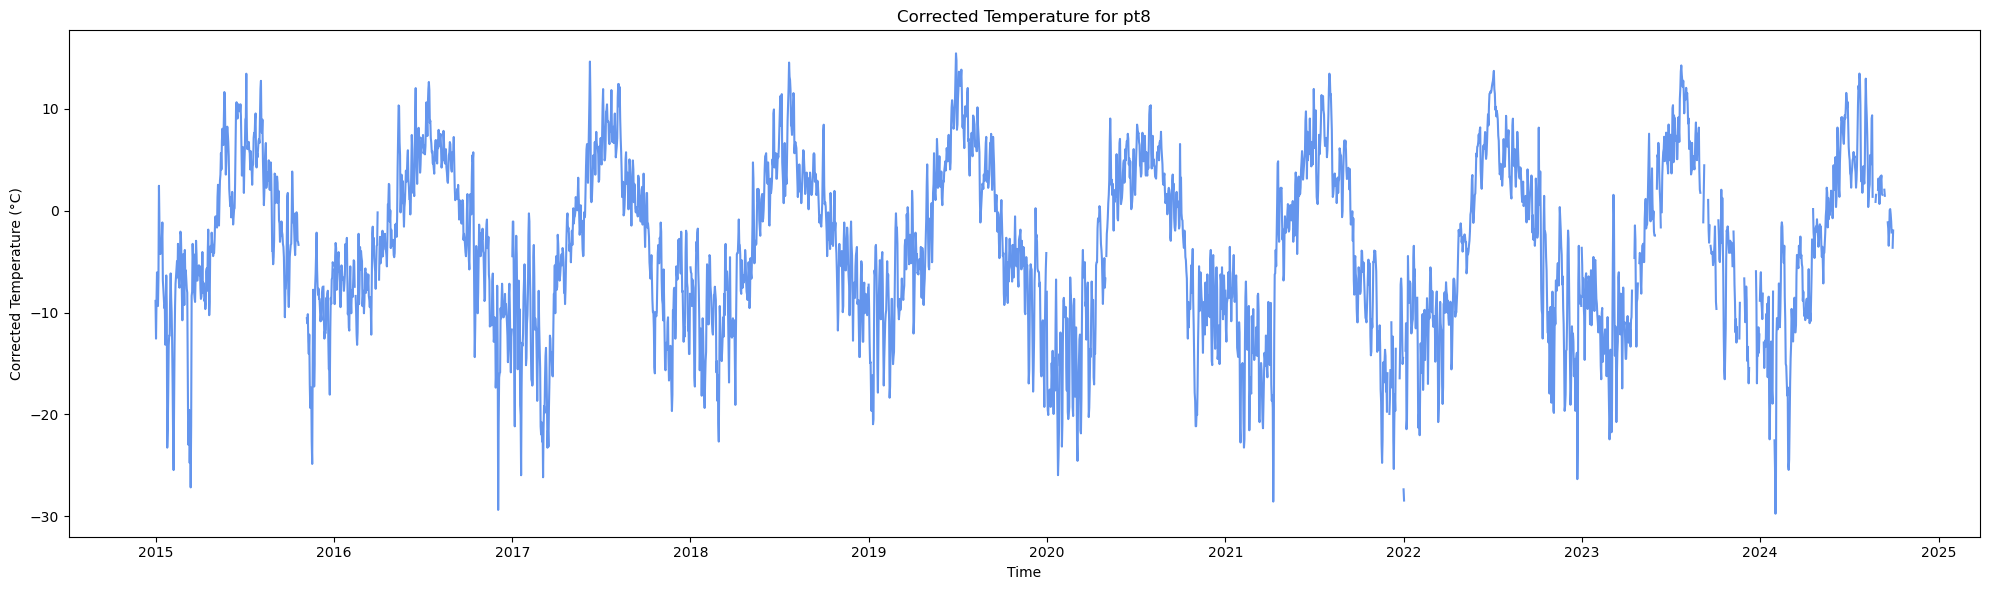

In [18]:
#get list of all points from the temperatures dictionary
all_points = set()
for years in temperatures.values():
    all_points.update(years.keys())

for pt in sorted(all_points):
    plt.figure(figsize=(20, 6))
    
    for year, points in temperatures.items():
        temp_df = yearly_dataframes[year]
        
        if pt in points:
            corrected_temp = points[pt]
            plt.plot(temp_df['time'], corrected_temp, color='cornflowerblue')
    
    plt.xlabel('Time')
    plt.ylabel('Corrected Temperature (°C)')
    plt.title(f'Corrected Temperature for {pt}')
    plt.tight_layout()
    plt.show()

## combine data (continuous record for each point) and export

In [19]:
for pt in sorted(all_points):
    continuous_record = pd.DataFrame()
    years_sorted = sorted(temperatures.keys())
    for year in sorted(years_sorted):
        if pt in temperatures[year]:
            temperature_series = temperatures[year][pt]
            time_series = yearly_dataframes[year]['time']

            df_year_point = pd.DataFrame({'time': time_series, 'corrected_temperature': temperature_series})
            continuous_record = pd.concat([continuous_record, df_year_point], ignore_index=True)
        continuous_record = continuous_record.sort_values(by='time').reset_index(drop=True) #sort by time
        continuous_record.to_csv(out_path + f'corrected_temperatures_{pt}.csv')
        print(f"Exported data for {pt} to CSV.")

Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt1 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt10 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt11 to CSV.
Exported data for pt12 to CSV.
Exported data for pt12 to CSV.
Exported data for 